# Coronavirus COVID-19 project
Objective: Find interesting positions based on the multiple alignment files

In [10]:
# Read fasta file

def read_fasta(fasta_file):

    fasta_dict = dict()
    with open (fasta_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            if '>' in line:
                key = line[1:-1]
                fasta_dict[key] = ''
            else:
                fasta_dict[key] += line[:-1]
    return fasta_dict

# Read aligned fasta file
aligned_fasta = '../dataset/regional_sequences/multiple_regional_sequences_aligned.fasta'
aligned_dict = read_fasta(aligned_fasta)

# Read unaligned fasta
unaligned_fasta = '../dataset/regional_sequences/multiple_regional_sequences_unaligned.fasta'
unaligned_dict = read_fasta(unaligned_fasta)

In [11]:
# Get accession names and prepare numpy array
import numpy as np

accession_array = []
aligned_seq_array = []
for name, sequence in aligned_dict.items():
    aligned_seq_array.append(list(sequence))
    accession_array.append(name.split('|')[0][:-1])
    
aligned_seq_array = np.array(aligned_seq_array)
accession_array = np.array(accession_array)

In [12]:
# Replace non A,T,G,C with -
aligned_seq_array = np.where(np.isin(aligned_seq_array, ['A', 'T', 'G', 'C']), aligned_seq_array, '-')

In [13]:
aligned_ref = aligned_seq_array[0, :]
unaligned_ref = np.array(list(unaligned_dict['NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome']))

In [14]:
# Get the dictionary of key ref. aligned position sequance, value reference actual position
aligned_pos_translator = dict() # Translate aligned position to unaligned position
ptr_1 = 0
ptr_2 = 0

while ptr_2 < len(unaligned_ref):
    if aligned_ref[ptr_1] == unaligned_ref[ptr_2]:
        aligned_pos_translator[ptr_1] = ptr_2
        
        ptr_1 += 1
        ptr_2 += 1
    
    else:
        ptr_1 += 1

unaligned_pos_translator = dict() # Make the opposite dictionary
for key, value in list(aligned_pos_translator.items()):
    unaligned_pos_translator[value] = key

In [15]:
# Count the bases on each position, then calculate the non NA ratios
# For each position, count how many As, Ts, Gs, Cs, and -s, represent them in a 5-dimensional vector with counts of A,T,G,C and - respectively.
def count_bases(position_vector):
    count_vector = np.zeros(5)
    bases = ['A', 'T', 'G', 'C', '-']
    
    for i in range(len(bases)):
        base = bases[i]
        
        # Filter
        base_filter = position_vector == base
        count_vector[i] += len(position_vector[base_filter])
    
    return count_vector

# Use count_bases()

base_counts = []
for pos in range(aligned_seq_array.shape[1]):
    position_vec = aligned_seq_array[:, pos]
    
    base_counts.append(count_bases(position_vec))
base_counts = np.array(base_counts).transpose()

In [16]:
# Get the base proportions for all non-NA entries

base_proportions = []
for pos in range(base_counts.shape[1]):
    position_vec = base_counts[:4, pos]
    sum_current_vec = np.sum(position_vec)
    base_proportions.append(position_vec/sum_current_vec)

base_proportions = np.array(base_proportions).transpose()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [17]:
# Get variance for each spot
var_aligned = np.var(base_proportions, axis = 0)

unalign_mask = np.isin(np.array([i for i in range(len(aligned_ref))]), list(aligned_pos_translator.keys())) # Mask aligned
var_unaligned = var_aligned[unalign_mask] # Position according to the original reference length

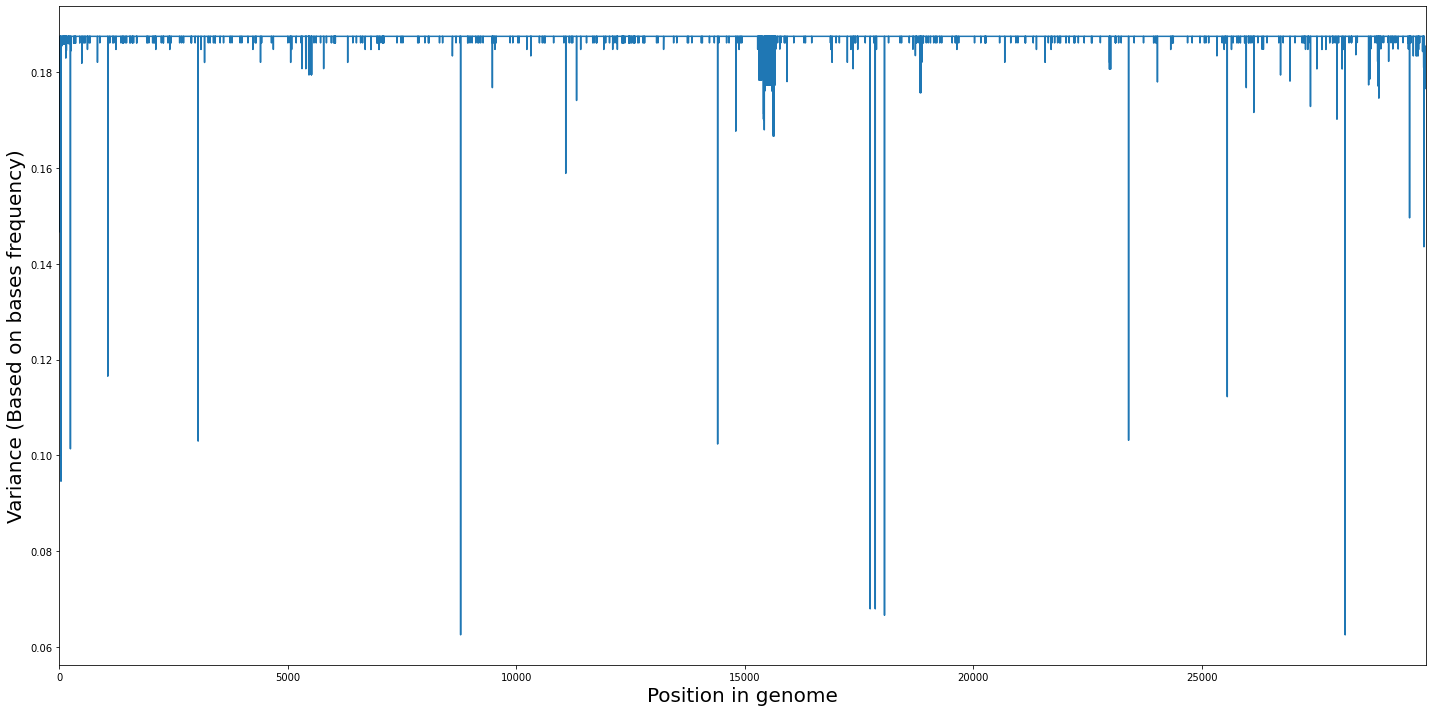

In [18]:
# Visualize variation in every spot

import matplotlib.pyplot as plt

def visualize_var(var_array):
    # Setup figure
    fig = plt.figure(figsize=(20, 10))
    plt.xlabel('Position in genome', size=20)
    plt.ylabel('Variance (Based on bases frequency)', size=20)
    plt.xlim((0, len(var_array)))
    
    # Prep data
    x_values = np.arange(len(var_array))
    y_values = var_array
    
    # Plot data
    plt.plot(x_values, y_values)
    plt.tight_layout()
    plt.savefig('../presentation/figures/variance_accross_genome.png')
    plt.show()
    
    
visualize_var(var_unaligned)

## Downstream analysis on positions of interest
Genes that code for protein for:
- ACE2
- RBD
- NSP2
- pp1a
- DPP4

In [278]:
# ALWAYS USE UNALIGNED!
def generate_variance_mask(ths, var_unaligned=var_unaligned): # Generate for unaligned position that has interesting positions
    mask = var_unaligned < ths
    return mask

def generate_roi_mask(start, end, unaligned_ref=unaligned_ref):
    # The start and end positions are indexed 1, so we adjust!
    adj_start = start - 1
    adj_end = end - 1
    
    # Position mask
    position_mask = np.repeat(False, len(unaligned_ref))
    position_mask[adj_start:adj_end + 1] = True
    
    return position_mask

In [279]:
# Get regions of interest (roi)
import pandas as pd
bed_path = '../dataset/interesting_regions.bed'

roi = pd.read_csv(bed_path,skiprows=1)

In [280]:
# Make dosage matrix (0 if same as reference, 1 if alternate)
dosage_matrix = np.zeros(aligned_seq_array[:, :].shape)
dosage_matrix[aligned_seq_array[:, :] != aligned_seq_array[0, :]] = 1

# Translate dosage matrix to reference positions
dosage_matrix = dosage_matrix[:, unalign_mask]

In [300]:
# Make one hot encoded matrix
from sklearn.preprocessing import OneHotEncoder as OHE

# enc = OHE(categories=[['A', 'T', 'G', 'C', '-']])
enc = OHE()
enc.fit(aligned_seq_array[0, :].reshape((aligned_seq_array[0, :].shape[0], 1)))

# Make ohe tensor
ohe_tensor = []

for i in range(aligned_seq_array.shape[0]):
    # Get one hot encoded 2d array from a single sequence
    current_seq = aligned_seq_array[i, :]
    curr_seq = current_seq.reshape((aligned_seq_array[i, :].shape[0], 1)) # Reshape array for ohe, diff variable so it's not in place
    
    # Transform to ohe
    curr_ohe = enc.transform(curr_seq)
    ohe_tensor.append(curr_ohe.toarray())
    
    
# Now we have 3-d ohe tensor with dimension 436 x 30025 x 5
ohe_tensor = np.array(ohe_tensor)
ohe_tensor = ohe_tensor[:, unalign_mask, :] # Now it's the same as reference

In [307]:
def get_dosage_matrix_interesting_regions(start, end, ths, dosage_matrix=dosage_matrix):
    '''
    Returns dosage matrix for a given region, with specific maximum variance threshold
    
    Args:
        - start: start position of region in reference genome
        - end: end position of region in reference genome
        - ths: maximum variance, # IF NO VARIANCE THS, USE ths = 1
    '''
    
    # Variance threshold mask
    ths_mask = generate_variance_mask(ths)

    
    # Generate region of interest mask
    roi_mask = generate_roi_mask(start, end)

    # Combine mask
    combined_mask = ths_mask & roi_mask
    filtered_dosage = dosage_matrix[:, combined_mask]
    
    
    return filtered_dosage


def get_ohe_tensor_interesting_regions(start, end, ths, ohe_tensor=ohe_tensor):
    '''
    Returns ohe tensor for a given region, with specific maximum variance threshold, the tensor counterpart of dosage matrix function above
    
    Args:
        - start: start position of region in reference genome
        - end: end position of region in reference genome
        - ths: maximum variance, # IF NO VARIANCE THS, USE ths = 1
    '''
        
    # Variance threshold mask
    ths_mask = generate_variance_mask(ths)

    
    # Generate region of interest mask
    roi_mask = generate_roi_mask(start, end)

    # Combine mask
    combined_mask = ths_mask & roi_mask
    filtered_ohe = ohe_tensor[:, combined_mask, :]
    
    
    return filtered_ohe
    
    
        
test_dosage = get_dosage_matrix_interesting_regions(1, 20000, 0.14)
test_ohe = get_ohe_tensor_interesting_regions(1, 20000, 0.14)

In [317]:
test_ohe.shape

(436, 12, 5)

In [319]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def conduct_pca_on_dosage_matrix(input_dosage):
    # Conduct PCA
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(input_dosage)
    
    # Get PC1 and PC2 matrix
    return PCs

def conduct_pca_on_ohe_tensor(input_tensor):
    # Conduct PCA
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(input_tensor)
    
    # Get PC1 and PC2 matrix
    return PCs

pca_test_dosage = conduct_pca_on_dosage_matrix(test_dosage)
pca_test_ohe = conduct_pca_on_ohe_tensor(test_ohe.reshape((test_ohe.shape[0], test_ohe.shape[1]*test_ohe.shape[2]))) # Flatten one hot encoded

## Parse meta information

In [320]:
# Parse meta info
meta_info = pd.read_csv('../dataset/accession_data.csv')
meta_info.loc[pd.isna(meta_info.loc[:, 'Geo_Location']), 'Geo_Location'] = 'NA' # CHange NA Value for simplicity

In [321]:
# Helper function, generate random color (copied)
import random

def rand_web_color_hex():
    rgb = ""
    for _ in "RGB":
        i = random.randrange(0, 2**8)
        rgb += i.to_bytes(1, "big").hex()
    return f'#{rgb}'

In [324]:
# Make color dictionary
col_dict = dict()

for geo_loc in list(set(meta_info.loc[:, 'Geo_Location'].values)):
    col_dict[geo_loc] = rand_web_color_hex()

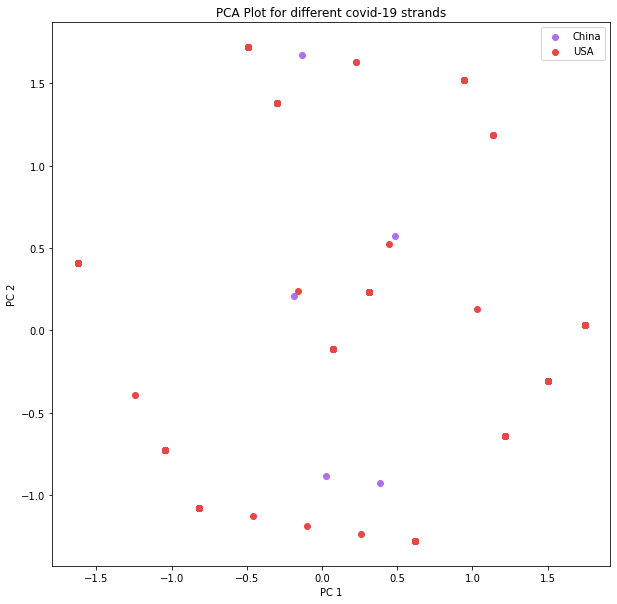

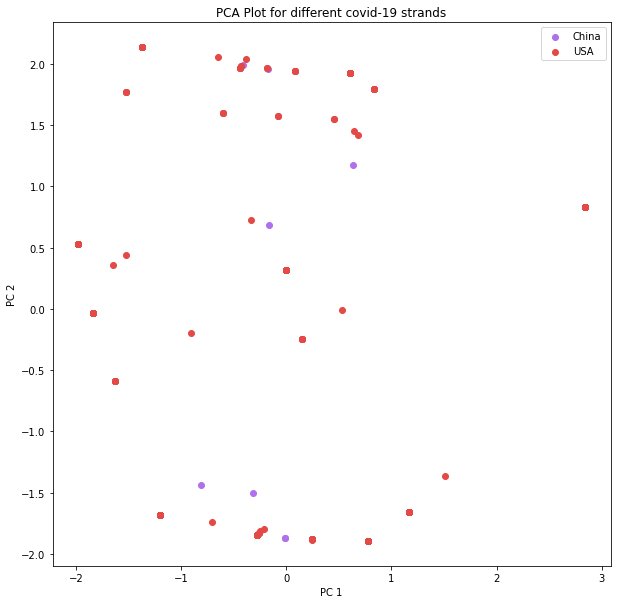

In [325]:
# Plot by region
import matplotlib.pyplot as plt
def plot_pca_by_region(PCs, col_dict=col_dict, meta_info=meta_info):
    # Make base plot
    fig = plt.figure(figsize=(10,10))
    plt.title('PCA Plot for different covid-19 strands')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    
    # Plot by region
    geo_list = list(set(meta_info.loc[:, 'Geo_Location'].values))
    for geo_loc in geo_list:
        if geo_loc in ['China', 'USA']:
#         if True:
            # Get color for region
            col = col_dict[geo_loc]

            # Get mask for the location
            geo_mask = meta_info.loc[:, 'Geo_Location'].values == geo_loc

            # Mask PCs
            PC1 = PCs[:, 0][geo_mask]
            PC2 = PCs[:, 1][geo_mask]

            # Plot PCs with color
            plt.scatter(PC1, PC2, c=col, label=geo_loc)
    
    plt.legend()
    plt.show()
        
        
plot_pca_by_region(pca_test_dosage)
plot_pca_by_region(pca_test_ohe)

In [11]:
# Get interesting positions
low_var_pos_unaligned = np.where(var_unaligned < 0.16)

In [12]:
import pandas as pd
gff_file = '../dataset/GCF_009858895.2_ASM985889v3_genomic.gff'
gff_df = pd.read_csv(gff_file, skiprows=7, sep='\t', names=['sequence','source','feature','start','end','score','strand','phase','attributes'])

def get_product(attribute):
    # Get product info from attribute
    # Split attribute
    att = attribute.split(';')
    # If ID=gene
    if 'ID=gene' in attribute:
        for sub_att in att:
            if 'gene=' in sub_att:
                gene_name = sub_att.split('=')[1]
                return gene_name
    
    elif 'ID=cds' in attribute:
        product_list = []
        for sub_att in att:
            if 'product' in sub_att:
                product = sub_att.split('=')[1]
                product_list.append(product)
            elif 'Note' in sub_att:
                note = sub_att.split('=')[1]
                product_list.append(note)
        return product_list
                

gff_df.loc[:, 'product'] = np.vectorize(get_product)(gff_df.loc[:, 'attributes'])


In [13]:
def search_feature(position, gff_df=gff_df):
    # Given reference unaligned position, output index of feature
    
    # Get filters
    start_filter = gff_df.loc[:, 'start'] <= position + 1
    end_filter = gff_df.loc[:, 'end'] >= position + 1
    comb_filter = start_filter & end_filter
    
    # Get products
    products = gff_df.loc[comb_filter, 'product'].values
    print(products)
    
    
    return products
    

In [233]:
low_var_pos_unaligned

(array([    0,    33,    34,    35,    36,   240,  1058,  3036,  8781,
        11082, 14407, 17746, 17857, 18059, 23402, 25562, 28143, 29552,
        29867]),)

In [234]:
np.vectorize(search_feature)(low_var_pos_unaligned)

[None None]
[None None]
[None None]
[None None]
[None None]
[None None]
[None None]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]


array([[array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',

In [238]:
aligned_seq_array.shape

(436, 30025)